Process dataset to obtain multimodal inputs

# Import dependency

In [2]:
import pandas as pd
from rdkit import RDLogger
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw
from utils.helm_utils import get_cycpep_smi_from_helm

pd.set_option('display.max_colwidth', None)

def show_mol_from_smi_large(smi):
    mol = Chem.MolFromSmiles(smi)
    img = Draw.MolToImage(mol, size=(800, 800))
    display(img)

def count_n_monomers(helm):
    return len(helm.split('.')) + len(helm.split('{')) - 2

train = False

# Cyclic peptides from CycPeptMPDB
Process all HELMS in DF to get SMILES

In [3]:
# train = True

if train:
    df_cycpdb = pd.read_csv('data/CycPeptMPDB/CycPeptMPDB_Peptide_All_flt.csv')
    df_cycpdb['smi'] = [get_cycpep_smi_from_helm(helm) for helm in df_cycpdb.HELM]
    len(df_cycpdb[df_cycpdb.smi.isna()]), len(df_cycpdb)
    display(df_cycpdb.helm_len.hist())
    display(df_cycpdb['Permeability'].hist(bins=50))
    
    # Split df_cycpdb into train, test
    df_cycpdb_all = df_cycpdb[['smi', 'HELM', 'Permeability']].rename(columns={'HELM': 'helm', 'Permeability': 'score'})
    df_cycpdb_all['n_mono'] = [count_n_monomers(helm) for helm in df_cycpdb_all.helm]

    df_cycpdb_all[['smi', 'helm', 'n_mono', 'score']].to_csv('data/CycPeptMPDB/all.csv', index=False)

    # Split df_cycpdb into train, test
    from sklearn.model_selection import train_test_split

    df_cycpdb_train, df_cycpdb_test = train_test_split(df_cycpdb_all, test_size=0.2, random_state=42)

    df_cycpdb_train[['smi', 'helm', 'score']].to_csv('data/CycPeptMPDB/train.csv', index=False)
    df_cycpdb_test[['smi', 'helm', 'score']].to_csv('data/CycPeptMPDB/test.csv', index=False)
else:
    df_cycpdb_all = pd.read_csv('data/CycPeptMPDB/all.csv')
    df_cycpdb_train = pd.read_csv('data/CycPeptMPDB/train.csv')
    df_cycpdb_test = pd.read_csv('data/CycPeptMPDB/test.csv')

display(df_cycpdb_train.head())
# df_cycpdb_train.sample(1).apply(lambda x: show_mol_from_smi_large(x['smi']), axis=1)

,smi,helm,n_mono,score
0,CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(CCOc2ccccc2)C(=O)[C@H](C)NC(=O)CN(Cc2ccccc2Cn2cccn2)C(=O)[C@H]2CCCN2C1=O,"PEPTIDE1{A.[Mono39].[meL].[Nle].[dP].[Mono45]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$",6,-5.38
1,CCCC[C@@H]1NC(=O)[C@@H](CC(C)C)N(C)C(=O)CN(CC2CCOCC2)C(=O)[C@@H](C)NC(=O)CN(Cc2ccc3c(c2)OCO3)C(=O)[C@@H]2CCCN2C1=O,"PEPTIDE1{[dA].[Mono38].[Me_dL].[Nle].P.[Mono1]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$",6,-6.64
2,CC(C)C[C@@H]1C(=O)N[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(Cc2ccccc2)CC(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[C@@H]2C(=O)N(C)[C@@H](C)C(=O)N1C,"PEPTIDE1{[dP].[meA].[Me_dL].[dL].P.[Bn_Gly].F}$PEPTIDE1,PEPTIDE1,1:R1-7:R2$$$",7,-10.00
3,CCCN1CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[C@H]2C1=O,"PEPTIDE1{P.[Pr_Gly].L.[dL].P.[dL].F}$PEPTIDE1,PEPTIDE1,1:R1-7:R2$$$",7,-5.89
4,CC(=O)N1CCC[C@H]1C(=O)N[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N(C)[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2CCC[C@@H]2C(=O)O[C@@H]1C,"PEPTIDE1{[ac-].P.T.[Me_dL].L.[Me_dL].[dL].[Me_dA].L.[dP]}$PEPTIDE1,PEPTIDE1,3:R3-10:R2$$$",10,-5.00


<AxesSubplot:>

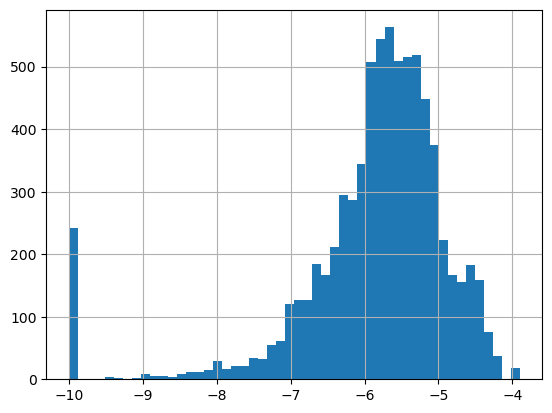

In [4]:
display(df_cycpdb_all['score'].hist(bins=50))

<AxesSubplot:>

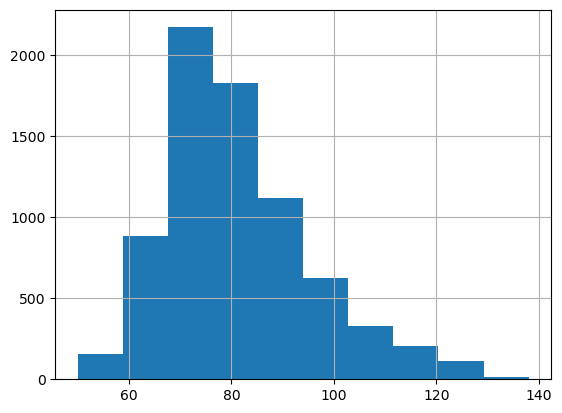

In [5]:
df_cycpdb_all['helm_len'] = df_cycpdb_all['helm'].str.len()
display(df_cycpdb_all['helm_len'].hist())

# Linear peptides from PeptideAtlas

In [5]:
# check if all amino acids are natural
def check_if_all_aas_are_natural(aa_seq):
    return all([aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in aa_seq])

def get_is_natural_aa(df):
    return [check_if_all_aas_are_natural(seq) for seq in df.aa_seq]

def get_helm_from_aa_seq(aa_seq):
    aa_seq = '.'.join(aa_seq)
    return f'PEPTIDE1{{{aa_seq}}}$$$$'

def get_linpep_smi_from_aa_seq(aa_seq):
    if 'X' in aa_seq:
        return None
    
    mol = Chem.MolFromSequence(aa_seq)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

In [6]:
def load_fasta_to_df(fa_path):
    line_list = []
    with open(fa_path, 'r') as f:
        line_list = f.readlines()
    
    ids, seqs = [], []
    for line in line_list:
        if line.startswith('>'):
            ids.append(line.strip().replace('>', ''))
            counter = 0
        else:
            seqs.append(line.strip())
            counter += 1
        
        if counter > 1:
            raise Exception(f'More than one line for sequence {id}')
    
    df = pd.DataFrame({'id': ids, 'aa_seq': seqs})
    return df

In [7]:
import pandas as pd
train = False

if train:
    # !ls ../Datasets/PeptideAtlas
    files = [
    'bburgdorferi_b31-201902-APD_BORBU_all.fasta',
    'celegans-201309-APD_Ce_all.fasta',
    'chicken-201607-APD_CHICK_all.fasta',
    'cow-201112-APD_Bt_all.fasta',
    'drosophila-201208-APD_Dm_all.fasta',
    'halobacterium-201308-APD_Ha_all.fasta',
    'honeybee-201309-APD_Apis_all.fasta',
    'horse-201304-APD_MYG_all.fasta',
    'Human-202012-APD_Hs_all.fasta',
    'leptospirainterrogans-201308-APD_Li_all.fasta',
    'mouse-201506-APD_Mm_all.fasta',
    'mtuberculosis-201307-APD_MTB_all.fasta',
    'pfalciparum-201209-APD_Pf_all.fasta',
    'pig-201411-APD_Pig_all.fasta',
    'rat-201311-APD_Rn_all.fasta',
    'staphylococcusaureuscol-201310-APD_STAAU_all.fasta',
    'staphylococcusaureushg001-201409-APD_STAAU_all.fasta',
    'streptococcus-200702-APD_Sp_all.fasta',
    'yeast-201303-APD_Sc_all.fasta',
    'zebrafish-201403-APD_Dr_all.fasta']

    for f in files:
        df = load_fasta_to_df(f'../Datasets/PeptideAtlas/{f}')
        df.to_csv(f'../Datasets/PeptideAtlas/csv/{f}.csv', index=False)

    # concat all csvs
    df_pa = pd.concat([pd.read_csv(f'../Datasets/PeptideAtlas/csv/{f}.csv') for f in files])

    # remove duplicates
    df_pa_redup = df_pa.drop_duplicates(subset=['aa_seq']).copy()

    len(df_pa), len(df_pa_redup)
    df_pa_redup['helm'] = [get_helm_from_aa_seq(seq) for seq in df_pa_redup.aa_seq]
    df_pa_redup['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_pa_redup.aa_seq]  # 43min 43s

    df_pa_redup['n_mono'] = [count_n_monomers(helm) for helm in df_pa_redup.helm]
    df_pa_redup['smi_len'] = df_pa_redup.smi.str.len()
    df_pa_redup = df_pa_redup[~df_pa_redup.smi.isnull()]
    df_pa_redup[['smi', 'helm', 'aa_seq', 'n_mono', 'smi_len']].to_csv('data/PeptideAtlas/all.csv', index=False)


    # split into train and test
    from sklearn.model_selection import train_test_split

    df_pa_train, df_pa_test = train_test_split(df_pa_redup, test_size=0.1, random_state=42)
    df_pa_train.to_csv('data/pretrain/PeptideAtlas/train.csv', index=False)
    df_pa_test.to_csv('data/pretrain/PeptideAtlas/test.csv', index=False)

    len(df_pa_train), len(df_pa_test)
else:
    df_pa_redup = pd.read_csv('data/pretrain/PeptideAtlas/all.csv')
    df_pa_train = pd.read_csv('data/pretrain/PeptideAtlas/train.csv')
    df_pa_test = pd.read_csv('data/pretrain/PeptideAtlas/test.csv')

display(df_pa_redup.head())
len(df_pa_redup), len(df_pa_train), len(df_pa_test)


,smi,helm,aa_seq,n_mono,smi_len
0,CSCC[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O)[C@@H](C)O,PEPTIDE1{P.M.K.D.E.T.F.G.E.Y.R}$$$$,PMKDETFGEYR,11,222.0
1,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)CN)[C@@H](C)O)[C@@H](C)O)[C@@H](C)CC)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)O,PEPTIDE1{G.L.G.T.D.E.D.T.L.I.E.I.L.A.S}$$$$,GLGTDEDTLIEILAS,15,282.0
2,CSCC[C@H](N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CS)C(=O)N[C@@H](CO)C(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CS)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O,PEPTIDE1{M.L.F.C.S.C.Q.D.Q.A.C.A.E.R}$$$$,MLFCSCQDQACAER,14,266.0
3,CC(C)C[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)O,PEPTIDE1{A.L.Q.Q.R.L.Q.G.A.E.E}$$$$,ALQQRLQGAEE,11,210.0
4,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](N)Cc1ccccc1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)O)[C@@H](C)O)[C@@H](C)O)C(C)C,PEPTIDE1{F.G.I.D.D.Q.D.Y.L.V.T.L.T}$$$$,FGIDDQDYLVTLT,13,269.0


(3238311, 2914479, 323832)

<AxesSubplot:>

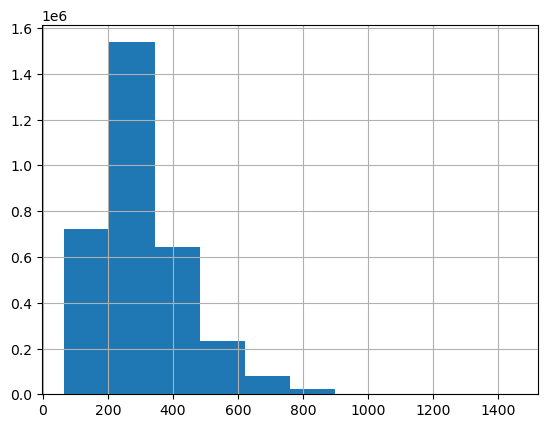

In [8]:
display(df_pa_redup.smi_len.hist())

<AxesSubplot:>

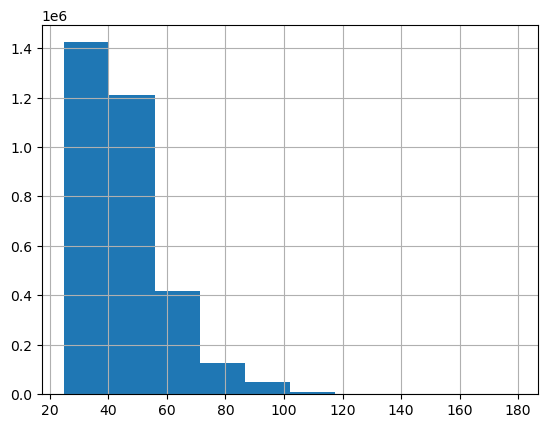

In [9]:
df_pa_redup['helm_len'] = df_pa_redup['helm'].str.len()
display(df_pa_redup['helm_len'].hist())

# HELMs from PubChem32

In [11]:
train = False

if train:
    df_pubchem = pd.read_csv('data/pretrain/chembl32/biotherapeutics_dict_prot_flt.csv')
    df_pubchem['n_mono'] = [count_n_monomers(helm) for helm in df_pubchem.HELM]
    df_pubchem_all = df_pubchem[['HELM', 'n_mono']].rename(columns={'HELM': 'helm'})

    df_pubchem_all.to_csv('data/pretrain/chembl32/all.csv', index=False)

else:
    df_pubchem_all = pd.read_csv('data/pretrain/chembl32/all.csv')

df_pubchem_all.columns

Index(['helm', 'n_mono'], dtype='object')

<AxesSubplot:>

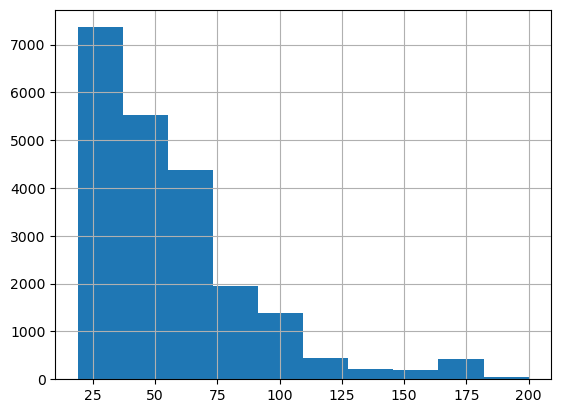

In [12]:
df_pubchem_all['helm_len'] = df_pubchem_all['helm'].str.len()
display(df_pubchem_all['helm_len'].hist())

In [15]:
# df_pubchem['smi'] = [get_cycpep_smi_from_helm(helm) for helm in df_pubchem.HELM]
# display(len(df_pubchem[df_pubchem.smi.isna()]), len(df_pubchem))
# display(df_pubchem.helm_len.hist())

# df_pubchem_nosmi = df_pubchem[df_pubchem.smi.isna()]
# df_pubchem_nosmi.to_csv('data/chembl32/pubchem_nosmi.csv', index=False)

In [16]:
# [get_cycpep_smi_from_helm(helm) for helm in df_pubchem_nosmi.HELM.head(10)]


# Merge dataset to pretrain models

<AxesSubplot:>

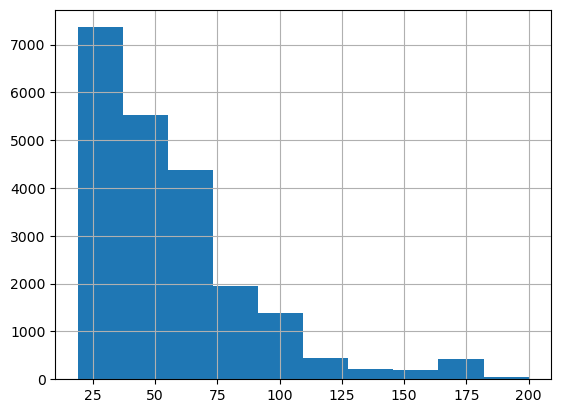

In [15]:

if train:
    cols = ['helm', 'n_mono']
    df_merged_helm = pd.concat([df_cycpdb_all[cols], df_pa_redup[cols], df_pubchem_all[cols]], axis=0, ignore_index=True)
    df_merged_helm.to_csv('data/pretrain/merged/all.csv', index=False)

    from sklearn.model_selection import train_test_split

    df_merged_helm_train, df_merged_helm_test = train_test_split(df_merged_helm, test_size=0.05, random_state=42)
    df_merged_helm_train.to_csv('data/pretrain/merged/train.csv', index=False)
    df_merged_helm_test.to_csv('data/pretrain/merged/test.csv', index=False)

else:
    df_merged_helm = pd.read_csv('data/pretrain/merged/all.csv')
    df_merged_helm_train = pd.read_csv('data/pretrain/merged/train.csv')
    df_merged_helm_test = pd.read_csv('data/pretrain/merged/test.csv')

df_pubchem_all['helm_len'] = df_pubchem_all['helm'].str.len()
display(df_pubchem_all['helm_len'].hist())